<a href="https://colab.research.google.com/github/shalomWu/Reliable-AI-Aided-Kalman-Filters/blob/main/AI_Aided_KF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import scipy.io

In [5]:
def kay_example13_3_v4(N, SNRdB, c, a=0.98, q_1=0.045, m=100.0, q_2=0.01):
    """
    Python translation of Kay_Example13_3_v_4.m
    Uses scalar-safe structure (from v3) but the full augmented Kalman filter (h,v).
    """
    p = 1  # single-tap channel (as in original code)
    QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)

    # Normalize QuADriga channel
    h_quad0 = c * np.sqrt(N / np.sum(np.abs(c)**2))
    H = h_quad0[:N].reshape(-1)  # shape (N,)

    # Outputs
    h_pred = np.zeros(N, dtype=complex)
    h_hat_classic = np.zeros(N, dtype=complex)

    # Ensure SNR array
    SNRdB = np.atleast_1d(SNRdB)

    dt = 0.09  # sampling interval

    for snr_db in SNRdB:
        snr_linear = 10 ** (snr_db / 10.0)
        rho = 1.0 / np.sqrt(snr_linear)

        # Input symbols (can use random QPSK if needed)
        v = np.ones(N)  # or np.random.choice(QPSK_vec, size=N)

        # Measurement: noiseless output
        y = np.conj(v) * H
        w = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)
        x = y + rho * w

        # --- Kalman filter matrices (2p×2p) ---
        A = np.block([
            [a*np.eye(p), dt*np.eye(p)],
            [np.zeros((p, p)), a*np.eye(p)]
        ])
        Q = np.block([
            [q_1*np.eye(p), np.zeros((p, p))],
            [np.zeros((p, p)), q_2*np.eye(p)]
        ])

        M_cov = m * np.eye(2*p)
        x_hat = np.zeros((2*p, N), dtype=complex)

        # Initialize state: h starts as first sample, v starts at 0
        x_hat[:, 0] = np.array([H[0], 0.0])
        h_pred[0] = H[0]
        h_hat_classic[0] = H[0]

        # --- Kalman filter loop ---
        for ii in range(1, N):
            # Predict
            x_pred = A @ x_hat[:, ii-1]
            M_pred = A @ M_cov @ A.T.conj() + Q

            # Measurement matrix C = [v[ii], 0]
            C = np.array([[v[ii], 0.0]])  # shape (1, 2p)

            # Kalman gain
            denom = rho**2 + C @ M_pred @ C.T.conj()
            K = (M_pred @ C.T.conj()) / denom

            # Innovation
            innov = x[ii] - (C @ x_pred).item()
            x_hat[:, ii] = x_pred + (K.flatten() * innov)

            # Covariance update
            M_cov = (np.eye(2*p) - K @ C) @ M_pred

            # Save channel estimates
            h_pred[ii] = x_pred[0]         # predicted h (prior)
            h_hat_classic[ii] = x_hat[0, ii]  # filtered h

    return h_pred, h_hat_classic



In [ ]:
def kay_example13_3_v3(N, SNRdB, c):
    """
    Python translation of Kay_Example13_3_v_2.m with scalar-extraction fixes.
    """
    # 1) Build the QPSK symbol set
    QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)

    # 2) Flatten & normalize channel vector
    #c = np.asarray(c, dtype=complex).reshape(-1)
    #if c.size < N:
    #    raise ValueError(f"Input c has length {c.size} < N={N}")
    h_quad0 = c * np.sqrt(N / np.sum(np.abs(c)**2))
    H = h_quad0[:N].reshape(-1)   # now H.shape == (N,)

    # 3) Prepare outputs
    h_pred         = np.zeros(N, dtype=complex)
    h_hat_classic  = np.zeros(N, dtype=complex)

    # 4) Kalman parameters (p=1)
    A     = 0.98 #1.0
    Q_mat = 0.045 #0.01  # scalar since p=1

    # 5) Ensure SNR vector
    SNRdB = np.atleast_1d(SNRdB)

    for snr_db in SNRdB:
        # convert to linear scale
        snr_linear = 10 ** (snr_db / 10.0)
        rho        = 1.0 / np.sqrt(snr_linear)

        # generate & flatten QPSK sequence
        #v = np.random.choice(QPSK_vec, size=N).ravel()
        v = np.ones(N)

        # noiseless channel output
        y = np.conj(v) * H

        # add AWGN & flatten
        w = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)
        x = (y + rho * w).ravel()

        # init Kalman arrays
        h_hat_local         = np.zeros(N, dtype=complex)
        h_pred_local        = np.zeros(N, dtype=complex)
        h_hat_classic_local = np.zeros(N, dtype=complex)
        M = 100.0

        # first sample = true channel
        h_hat_local[0]         = H[0]
        h_pred_local[0]        = H[0]
        h_hat_classic_local[0] = H[0]

        # 6) Kalman loop
        for ii in range(1, N):
            # predict
            h_pred_local[ii] = A * h_hat_local[ii-1]
            M = A * M * A + Q_mat

            # gain
            V_ii  = v[ii]
            denom = rho**2 + (np.abs(V_ii)**2)*M
            K     = (M * np.conj(V_ii)) / denom

            # extract scalars
            K_val    = K.item()    if hasattr(K, "shape") and K.shape==() else K
            x_val    = x[ii].item() if hasattr(x[ii], "shape") else x[ii]
            V_val    = V_ii.item() if hasattr(V_ii, "shape") else V_ii
            hp_val   = h_pred_local[ii].item() if hasattr(h_pred_local[ii], "shape") else h_pred_local[ii]

            # update
            h_hat_local[ii] = hp_val + K_val * (x_val - V_val * hp_val)
            h_hat_classic_local[ii] = h_hat_local[ii]

            # covariance update
            M = (1 - K_val * V_val) * M

        # save “last‐SNR” result
        h_pred         = h_pred_local.copy()
        h_hat_classic  = h_hat_classic_local.copy()

    return h_pred, h_hat_classic


In [ ]:
def kay_example13_3_v2(N, SNRdB, c):
    """
    Python translation of Kay_Example13_3_v_2.m

    Parameters
    ----------
    N : int
        Number of channel samples (same as MATLAB’s “N”).
    SNRdB : array-like of shape (K,)
        SNR values in dB. MATLAB code allows this to be a vector,
        so we loop over each SNRdB[k].
    c : array-like of shape (>= N,)
        Complex channel vector from QuADriga. MATLAB code uses this to build h_0.

    Returns
    -------
    h_pred : np.ndarray of shape (N,)
        The “predicted” channel values (for the **last** SNR in SNRdB).
    h_hat_classic : np.ndarray of shape (N,)
        The “classic” (updated) channel estimate (for the **last** SNR in SNRdB).
    """

    # --- 1) Build the QPSK symbol set (MATLAB used randsrc with QPSK_vec) ---
    #    QPSK_vec = [1+1j, 1-1j, -1+1j, -1-1j] / sqrt(2)
    QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    #print(QPSK_vec, QPSK_vec.dtype, QPSK_vec.shape)
    # --- 2) Normalize the channel “c” exactly like MATLAB’s:
    #    h_Quad_0 = c * sqrt(N / sum(abs(c).^2));
    #    Then h_0 = h_Quad_0(1:N)
    #    MATLAB’s “c” is a vector ≥ length N; we slice off the first N samples.
    #c = np.asarray(c, dtype=complex).reshape(-1)
    h_quad0 = c * np.sqrt(N / np.sum(np.abs(c)**2))
    h0 = h_quad0[:N]     # shape: (N,)
    h0 = np.asarray(h0).reshape(-1)
    # In MATLAB: H = [h_0];  (just a 1×N row). In Python, we'll treat H as a 1D array of length N:
    H = h0.copy()        # shape: (N,)


    # Pre-allocate outputs (only last‐SNR is returned)
    h_pred = np.zeros(N, dtype=complex)
    h_hat_classic = np.zeros(N, dtype=complex)

    # Kalman filter parameters (p = 1 in MATLAB code)
    p = 1
    A = 1.0                      # A = 1*eye(p)  → scalar 1
    Q_mat = 0.01 * np.eye(p)     # Q = 0.01*eye(p) → scalar 0.01
    # Note: since p=1, we’ll simply treat M and Q as scalars below.

    # If SNRdB is a scalar, convert to 1D array:
    SNRdB = np.atleast_1d(SNRdB)

    for k_idx, snr_db in enumerate(SNRdB):
        # --------------------------------------
        # This loop corresponds to: for k = 1:length(SNRdB)
        # --------------------------------------

        # 3) Convert dB→linear:
        snr_linear = 10 ** (snr_db / 10.0)

        # 4) Generate a random QPSK sequence “v” of length N:
        #    MATLAB: v = randsrc(1,N,QPSK_vec);
        #    → In NumPy, pick uniformly from QPSK_vec:
        #np.random.seed(12345)
        #v = np.random.choice(QPSK_vec, size=N)
        v = np.ones(N)
        #print(v[:5])#, np.abs(v[:5]))

        # 5) Form the “noiseless” channel output y:
        #    MATLAB: y = diag(conj(V)*H)'  where V = [v(1:end)]'
        #    Because V is Nx1 and H is 1×N, diag(conj(V)*H) picks elementwise conj(v[i])*H[i].
        #    So: y[i] = conj(v[i]) * H[i]
        y = np.conj(v) * H        # shape: (N,)

        # 6) Add AWGN noise:
        #    rho = 1./sqrt(SNR(k))
        rho = 1.0 / np.sqrt(snr_linear)

        #    w = (randn(1,length(y)) + 1i*randn(1,length(y))) / sqrt(2);
        w = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

        #    x = y + rho * w
        x = y + rho * w           # shape: (N,)

        # --------------------------------------
        # 7) Initialize Kalman quantities (for this SNR)
        # --------------------------------------
        #    h_hat  = exp(-1i * theta)*ones(p,N)
        #    h_pred = exp(-1i * theta)*ones(p,N)
        #    h_hat_Classic = ones(p,N)
        #
        #    In MATLAB, theta = pi/4, but note how they never use theta further (they overwrite h_hat(:,1) right away).
        #    We’ll initialize simply with zeros (and set the first sample to H[0]).
        #
        theta = np.pi / 4   # MATLAB code declares it, but never uses in final calc.
        h_hat = np.zeros(N, dtype=complex)
        h_pred_local = np.zeros(N, dtype=complex)
        h_hat_classic_local = np.zeros(N, dtype=complex)

        #    M = 100*eye(p)  → scalar 100
        M = 100.0

        #    Amit is the best!!!! I love her
        #    h_hat(:,1) = H(:,1)   and   h_pred(:,1) = H(:,1)'
        #    Because H is 1×N in MATLAB, H(:,1) is H(1,1) i.e. the first element of h0.
        h_hat[0] = H[0]
        h_pred_local[0] = H[0]
        h_hat_classic_local[0] = H[0]

        # --------------------------------------
        # 8) Run the Kalman loop for i=2:N  (MATLAB indices 2→N map to Python 1→N-1)
        # --------------------------------------
        for ii in range(1, N):
            # 8a) Predict step:
            #     h_hat(:,ii) = A * h_hat(:,ii-1)
            #     h_pred(:,ii) = h_hat(:,ii)'   (they then use h_pred for next step)
            h_pred_local[ii] = A * h_hat[ii - 1]
            M = A * M * A + Q_mat  # Q_mat is 0.01 (scalar)

            # 8b) Compute Kalman gain:
            #     K = (M * V(ii,:)') / (rho^2 + V(ii,:)*M*V(ii,:)')
            #     Here V(ii,:) is the ii-th QPSK symbol (scalar).  Conj/V is handled in elementwise fashion.
            V_ii = v[ii]
            denom = (rho ** 2) + (np.abs(V_ii) ** 2) * M
            K = (M * np.conj(V_ii)) / denom

            # 8c) Update step:
            #     h_hat(:,ii) = h_hat(:,ii) + K * (x(ii) - V(ii,:) * h_hat(:,ii))
            #     Notice: h_hat(:,ii) was set to h_pred_local[ii] above
            h_hat[ii] = h_pred_local[ii] + K * (x[ii] - V_ii * h_pred_local[ii])
            h_hat_classic_local[ii] = h_hat[ii]

            # 8d) Covariance update:
            #     M = (I - K * V(ii,:)) * M   → scalars reduce to:
            #     M = (1 - K * V_ii) * M
            M = (1 - K * V_ii) * M

        # At the end of this “for k” loop iteration,
        # MATLAB’s code overwrote h_pred and h_hat_Classic each SNR—
        # thus after the loop finishes, h_pred and h_hat_Classic correspond to the *last* SNR in SNRdB.
        h_pred = h_pred_local.copy()
        h_hat_classic = h_hat_classic_local.copy()

        # (MATLAB also computed MSE and MSE_pred here, but those are not returned by the function;
        #  if you need those, you can replicate the same logic in Python.)

    # Return the predicted and classic estimates for the LAST SNR in SNRdB
    return h_pred, h_hat_classic


(4, 4, 5285)
[0.0007594 -0.00255664j 0.00066306-0.00258235j 0.00056578-0.00260445j
 0.00046768-0.0026229j  0.0003689 -0.00263768j]


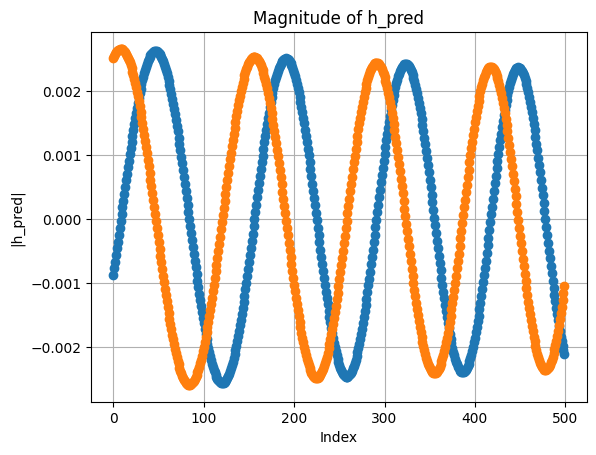

In [ ]:
%matplotlib inline
#data = scipy.io.loadmat('/content/myComplexVec.mat')
#c = data['c']
K=500
mat = scipy.io.loadmat('/content/Channel_H_4x4.mat')
c = mat['H']   # expect shape (N_Rx, M_Tx, N)
print(c.shape)

print(c[1,1,:5])#, np.abs(v[:5]))
plt.figure()
plt.plot(np.real(c[1,0,:K].reshape(-1)), marker='o')
plt.plot(np.imag(c[1,0,:K].reshape(-1)), marker='o')
plt.title("Magnitude of h_pred")
plt.xlabel("Index")
plt.ylabel("|h_pred|")
plt.grid(True)
plt.show()

In [ ]:
# Example inputs (you’ll replace these with your actual data)
N = 5285

SNRdB = np.array([30])      # can be any list or 1D array of SNR values
# Suppose 'c' is your QuADriga channel vector of length >= N
# For demonstration, let's use a random complex vector:
#c = data['c'] #(np.random.randn(N) + 1j * np.random.randn(N))
C = c[1,1,:].reshape(-1)

# Now call the translated function:
h_pred, h_hat_classic = kay_example13_3_v3(N, SNRdB, C)
#h_pred, h_hat_classic = kay_example13_3_v4(N, SNRdB, C,0.98,0.01,1,0.04)  #(N, SNRdB, c, a, q_1, m, q_2)
 #h_pred and h_hat_classic are both arrays of length N (for the LAST SNR value)
#plot("h_pred (first 10 samples):", h_pred[:10])
#print("h_hat_classic (first 10 samples):", h_hat_classic[:10])
#plt.figure()


In [ ]:
print(C[:5])#, np.abs(v[:5]))
print(h_pred[:5])#

[0.00094625+0.00059156j 0.00094792+0.00058851j 0.0009496 +0.00058544j
 0.00095128+0.00058236j 0.00095295+0.00057925j]
[1.13965251+0.71246683j 1.11685946+0.69821749j 1.14618145+0.70286647j
 1.0978159 +0.71397253j 1.13197035+0.68673006j]


In [ ]:
h_hat_classic=h_hat_classic.reshape(-1)
h_pred=h_pred.reshape(-1)
print(h_hat_classic[:5])#

[1.13965251+0.71246683j 1.16914013+0.71705475j 1.12764208+0.72080076j
 1.14669173+0.69820652j 1.17958678+0.6666405j ]


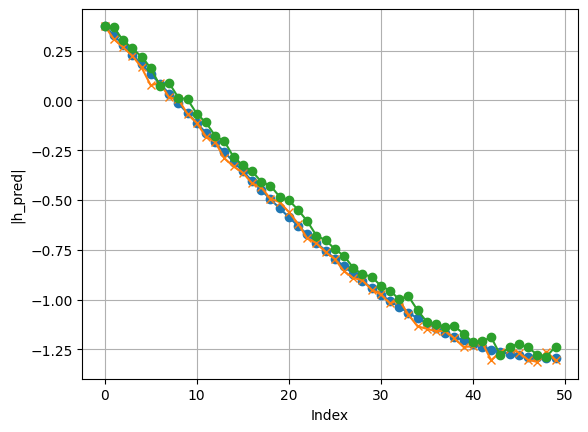

In [ ]:
K=50
print
plt.plot(np.arange(K), np.real(C[:K]*np.sqrt(N / np.sum(np.abs(C)**2))), marker='o')
plt.plot(np.arange(K), np.real(h_hat_classic[:K]), marker='x')
plt.plot(np.arange(K), np.real(h_pred[:K]), marker='o')
plt.xlabel("Index")
plt.ylabel("|h_pred|")
plt.grid(True)
plt.show()

# Looping various SNR to get the KF NMSE

(4, 4, 5285)
SNR: 0.0 dB
SNR: 0.5 dB
SNR: 1.0 dB
SNR: 1.5 dB
SNR: 2.0 dB
SNR: 2.5 dB
SNR: 3.0 dB
SNR: 3.5 dB
SNR: 4.0 dB
SNR: 4.5 dB
SNR: 5.0 dB
SNR: 5.5 dB
SNR: 6.0 dB
SNR: 6.5 dB
SNR: 7.0 dB
SNR: 7.5 dB
SNR: 8.0 dB
SNR: 8.5 dB
SNR: 9.0 dB
SNR: 9.5 dB
SNR: 10.0 dB
SNR: 10.5 dB
SNR: 11.0 dB
SNR: 11.5 dB
SNR: 12.0 dB
SNR: 12.5 dB
SNR: 13.0 dB
SNR: 13.5 dB
SNR: 14.0 dB
SNR: 14.5 dB
SNR: 15.0 dB
SNR: 15.5 dB
SNR: 16.0 dB
SNR: 16.5 dB
SNR: 17.0 dB
SNR: 17.5 dB
SNR: 18.0 dB
SNR: 18.5 dB
SNR: 19.0 dB
SNR: 19.5 dB
SNR: 20.0 dB
SNR: 20.5 dB
SNR: 21.0 dB
SNR: 21.5 dB
SNR: 22.0 dB
SNR: 22.5 dB
SNR: 23.0 dB
SNR: 23.5 dB
SNR: 24.0 dB
SNR: 24.5 dB
SNR: 25.0 dB
SNR: 25.5 dB
SNR: 26.0 dB
SNR: 26.5 dB
SNR: 27.0 dB
SNR: 27.5 dB
SNR: 28.0 dB
SNR: 28.5 dB
SNR: 29.0 dB
SNR: 29.5 dB
SNR: 30.0 dB
SNR: 30.5 dB
SNR: 31.0 dB
SNR: 31.5 dB
SNR: 32.0 dB
SNR: 32.5 dB
SNR: 33.0 dB
SNR: 33.5 dB
SNR: 34.0 dB
SNR: 34.5 dB
SNR: 35.0 dB
SNR: 35.5 dB
SNR: 36.0 dB
SNR: 36.5 dB
SNR: 37.0 dB
SNR: 37.5 dB
SNR: 38.0 dB
SNR: 3

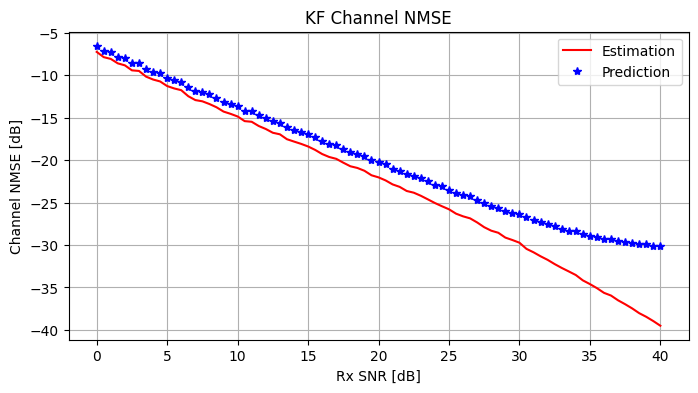

In [ ]:

#mat = scipy.io.loadmat('/content/Channel_H_64x6.mat')
mat = scipy.io.loadmat('/content/Channel_H_4x4.mat')
h = mat['H']   # expect shape (N_Rx, M_Tx, N)
print(h.shape)

Ch=h[1,1,:].reshape(-1)*np.sqrt(N / np.sum(np.abs(h[1,1,:].reshape(-1))**2))
# 2) Parameters
SNRdB = np.arange(0, 40.5, 0.5)   # 0:0.5:30
N     = 5285
p     = 1

# 3) Extract & normalize the channel “c” exactly like MATLAB did:
#    MATLAB: c = squeeze(H(1,1,:))';


# 4) Prealloc arrays
MSE      = np.zeros_like(SNRdB)
MSE_pred = np.zeros_like(SNRdB)

# 5) Loop over each SNR, call your Python KF, compute normalized MSE
for idx, snr in enumerate(SNRdB):
    print(f"SNR: {snr} dB")
    # Kay_Example13_3_v_2 → kay_example13_3_v2
    #h_pred, h_hat = kay_example13_3_v3(N, np.array([snr]), Ch)
    h_pred, h_hat = kay_example13_3_v4(N, np.array([snr]), Ch,0.98,0.01,1,0.04)
    #h_hat=h_hat.reshape(-1)
    #h_pred=h_pred.reshape(-1)
    # MATLAB did: Quad = c; then
    # MSE_pred(k)=mean((abs(Quad(2*p:end-p)-h_pred(1,2*p:end-p)).^2)./abs(Quad(2*p:end-p)).^2);
    seg = slice(2*p, -p)   # Python indexing 2*p : N-p

    err_pred = np.abs(Ch[seg] - h_pred[seg])**2 \
               / np.abs(Ch[seg])**2
    err_hat  = np.abs(Ch[seg] - h_hat[seg])**2 \
               / np.abs(Ch[seg])**2

    MSE_pred[idx] = np.mean(err_pred)
    MSE[idx]      = np.mean(err_hat)

# 6) Plot the results exactly as your MATLAB figures
plt.figure(figsize=(8,4))
plt.plot(SNRdB, 10*np.log10(MSE),  'r-',  label='Estimation')
plt.plot(SNRdB, 10*np.log10(MSE_pred),'b*', label='Prediction')
plt.grid(True)
plt.xlabel('Rx SNR [dB]')
plt.ylabel('Channel NMSE [dB]')
plt.title('KF Channel NMSE')
plt.legend()
plt.show()


# Main loop taking matrix H and finding the rate

In [6]:
# ── cell 1: imports & helper functions ──────────────────────────────────────────
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.optimize import brentq

def ser_to_rate(SNR_dB, SER_qpsk):
    """
    Python port of SERtoRate.m
    Inputs:
      SNR_dB    : 1D array of SNR values in dB
      SER_qpsk  : 1D array of measured QPSK SER (same length)
    Returns:
      R         : 1D array of achievable rate [bits/s/Hz]
    """
    # adjust 3dB offset
    SNR_lin_ref = 10 ** ((SNR_dB - 3) / 10.0)

    # Q-function
    Q = lambda x: 0.5 * erfc(x / np.sqrt(2))
    QPSK_SER_awgn = lambda snr: 2*Q(np.sqrt(2*snr)) - Q(np.sqrt(2*snr))**2

    SNR_eff = np.ones_like(SER_qpsk, dtype=float)
    for i, ser in enumerate(SER_qpsk):
        if ser <= 0:
            SNR_eff[i] = np.inf
        elif ser >= 0.65:
            SNR_eff[i] = 0.0
        else:
            # invert QPSK_SER_awgn(snr) = ser  on [1e-6, 1e2]
            SNR_eff[i] =  brentq(lambda snr: QPSK_SER_awgn(snr) - ser,1e-6, 1e2)


    # capacity estimate
    return np.log2(1.0 + SNR_eff)
    #return SNR_eff

In [ ]:
mat = scipy.io.loadmat('/content/SER.mat')
SER = mat['SER']   # expect shape (N_Rx, M_Tx, N)
print(SER.shape)

plt.figure(figsize=(8,4))
plt.semilogy(np.arange(0, 15.5, 0.5),SER[0,:],'o')
plt.semilogy(np.arange(0, 15.5, 0.5),SER[1,:],'o')
plt.grid(True)
plt.xlabel('SER [dB]')
plt.ylabel('SNR [dB]')
plt.title('SER')
plt.legend()
plt.show()


This is main Eigen BF code

In [ ]:
# ── cell 2: main simulation ────────────────────────────────────────────────────

# 1) Load H from your .mat file
mat = scipy.io.loadmat('/content/Channel_H_4x4.mat')
H_mat = mat['H']   # expect shape (N_Rx, M_Tx, N)

# 2) System parameters
SNRdB          =  np.arange(0, 15, 1)
SNRdB_theory  = SNRdB # np.arange(0, 15.5, 0.5)
SNR_lin       = 10**(SNRdB/10)
SNR_lin_th    = 10**(SNRdB_theory/10)

N_Rx, M_Tx, N = H_mat.shape
p             = 5

# 3) Preallocate
SER          = np.zeros((N_Rx, len(SNRdB)))
SumRateAvg   = np.zeros(len(SNRdB))

# 4) QPSK alphabet (for s generation)
QPSK_vec = np.array([1+1j,1-1j,-1+1j,-1-1j]) / np.sqrt(2)
#s      = np.random.choice(QPSK_vec, size=(N_Rx, N))
#mat = scipy.io.loadmat('/content/Source_4.mat')
#s = mat['s']   # expect shape (N_Rx, M_Tx, N)

y=np.zeros((N_Rx,N),dtype=complex)

# 5) Ask which channel estimate to use
EstimationMethod = int(input("Known=0, KF=1, BestEst=2: "))

# 6) Loop over SNRs
for k, snr_db in enumerate(SNRdB):
    print(f">>> SNR = {snr_db} dB")

    # 6.1) Normalize & KF-estimate every (n,m)-link
    H_norm        = np.zeros_like(H_mat, dtype=complex)
    h_KF          = np.zeros_like(H_mat, dtype=complex)
    h_hat_Classic = np.zeros_like(H_mat, dtype=complex)
    s_hat = np.zeros((N_Rx, N), dtype=complex)

    for n in range(N_Rx):
        for m in range(M_Tx):

            c = H_mat[n,m,:].reshape(-1)
            norm_val = np.sqrt(N / np.sum(np.abs(H_mat[n,m,:].reshape(-1))**2))
            if norm_val != 0:
                c_norm = c * norm_val
                H_norm[n,m,:] = c_norm
                h_pred, h_hat = kay_example13_3_v3(N, np.array([snr_db]), c_norm)
                h_KF[n,m,:] = h_pred.reshape(-1)
                h_hat_Classic[n,m,:] = h_hat.reshape(-1)

    # 6.2) Generate symbols & noise
    s      = np.random.choice(QPSK_vec, size=(N_Rx, N))
    noise  = (np.random.randn(N_Rx, N) + 1j*np.random.randn(N_Rx, N)) / np.sqrt(2)
    rho    = 1.0 / np.sqrt(10**(snr_db/10))

    # 6.3) Per-snapshot SumRate
    SumRate = np.zeros(N)
    for ii in range(N):
        # pick channel for precoding
        if   EstimationMethod == 0:
            H_curr = H_norm[:,:,ii]
        elif EstimationMethod == 1:
            H_curr = h_KF[:,:,ii]
        else:
            H_curr = h_hat_Classic[:,:,ii]

        # SVD and precoder
        _,_,V = np.linalg.svd(H_curr)
        w = V.conj().T
        #print(S)

        # receive & rate
        tx_vec = w[:,:N_Rx] @ s[:,ii]
        y[:,ii]      = (1/np.sqrt(M_Tx)) * (H_norm[:,:,ii] @ tx_vec) + rho*noise[:,ii]
        SumRate[ii] = np.log2( np.linalg.norm(
            np.eye(N_Rx) + (1/(N_Rx*rho**2)) * H_norm[:,:,ii] @ w[:,:N_Rx] @ w[:,:N_Rx].conj().T @ H_norm[:,:,ii].conj().T,
            2
        ) )
        s_hat[:,ii] = np.linalg.pinv((1/np.sqrt(M_Tx))*H_norm[:,:,ii] @ w[:,:N_Rx]) @ y[:,ii]



    SumRateAvg[k] = np.mean(SumRate)

    # 6.4) Zero-Forcing slicer → SER
    #    s_hat shape (N_Rx, N-1)
    #s_hat = np.zeros((N_Rx, N), dtype=complex)
    #for ii in range(N):
        #H_curr = {0:H_norm,1:h_KF,2:h_hat_Classic}[EstimationMethod][:,:,ii]
        #w = np.linalg.svd(H_norm[:,:,ii])[2]
        #y = (1/np.sqrt(M_Tx))*(H_norm[:,:,ii] @ (w[:,:N_Rx] @ s[:,ii])) + rho*noise[:,ii]
        #s_hat[:,ii] = np.linalg.pinv((1/np.sqrt(M_Tx))*H_norm[:,:,ii] @ w[:,:N_Rx]) @ y[:,ii]

    # hard decision & SER
    #for jj in range(N_Rx):
    s_tilde = (np.sign(np.real(s_hat))/np.sqrt(2)
              + 1j*np.sign(np.imag(s_hat))/np.sqrt(2))
    errors  = np.sum(np.abs(s_tilde - s)> np.finfo(float).eps, axis=1)
    SER[:,k] = errors / (N)


    #SER[:,k] = errors / (N)

# 7) Theoretical SER for Spatial Multiplexing
P_err_linear = 1.0/((1 + ((N_Rx/M_Tx)*SNR_lin_th)/(2*N_Rx))**N_Rx)




Known=0, KF=1, BestEst=2: 0
>>> SNR = 0 dB
>>> SNR = 1 dB
>>> SNR = 2 dB
>>> SNR = 3 dB
>>> SNR = 4 dB
>>> SNR = 5 dB
>>> SNR = 6 dB
>>> SNR = 7 dB
>>> SNR = 8 dB
>>> SNR = 9 dB
>>> SNR = 10 dB
>>> SNR = 11 dB
>>> SNR = 12 dB
>>> SNR = 13 dB
>>> SNR = 14 dB


In [ ]:
print(H_norm[:,:,0])

In [ ]:
print(y[:,0])

In [ ]:
print(w[:,0])

In [ ]:
print(w @ w.conj().T)

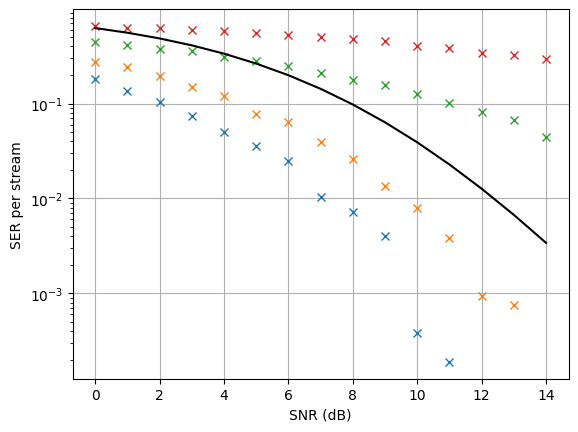

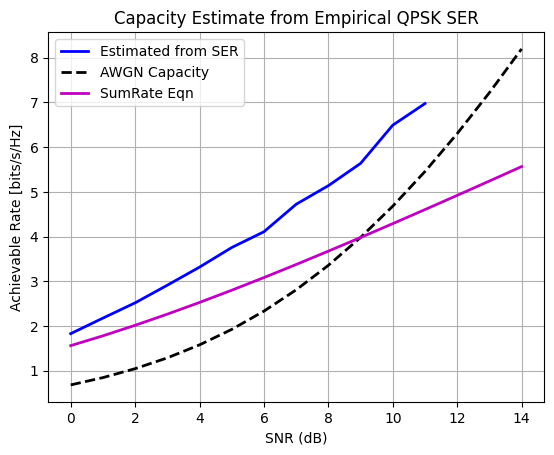

In [ ]:
# 8) Plot SER vs. theory
plt.figure()
for rx in range(N_Rx):
    plt.semilogy(SNRdB, SER[rx,:], 'x')

plt.semilogy(SNRdB, P_err_linear, 'k-')
plt.xlabel('SNR (dB)')
plt.ylabel('SER per stream')
plt.grid(True)

# 9) Aggregate estimated rates
R = np.zeros_like(SNRdB, dtype=float)
for rx in range(N_Rx):
    R += ser_to_rate(SNRdB, SER[rx,:])

# 10) Final capacity plot
plt.figure()
plt.plot(SNRdB, R,           'b-', linewidth=2, label='Estimated from SER')
plt.plot(SNRdB, N_Rx*np.log2(1 + SNR_lin/2/N_Rx), 'k--', linewidth=2, label='AWGN Capacity')
plt.plot(SNRdB, SumRateAvg,  'm-', linewidth=2, label='SumRate Eqn')
plt.xlabel('SNR (dB)')
plt.ylabel('Achievable Rate [bits/s/Hz]')
plt.title('Capacity Estimate from Empirical QPSK SER')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

RF Cascaded NF

In [ ]:
import numpy as np

def total_noise_figure(stages):
    """
    Calculate the total noise factor and noise figure for a cascade of RF stages.

    Parameters
    ----------
    stages : list of tuples
        Each tuple contains (gain_dB, NF_dB) for each stage. For attenuators,
        NF_dB should be set equal to the loss in dB.

    Returns
    -------
    F_tot : float
        Total noise factor (linear).
    NF_tot_dB : float
        Total noise figure in dB.
    """
    # Convert dB values to linear
    G = [10**(gain/10) for gain, _ in stages]
    F = [10**(nf/10) for _, nf in stages]

    # Friis formula
    F_tot = F[0]
    cumulative_gain = G[0]
    for Fi, Gi in zip(F[1:], G[1:]):
        F_tot += (Fi - 1) / cumulative_gain
        cumulative_gain *= Gi

    NF_tot_dB = 10 * np.log10(F_tot)
    return F_tot, NF_tot_dB

# Define the RF chain: (gain_dB, NF_dB) for each stage
stages = [
    (-1.1, 1.1),  # Attenuator 1
    (20.0, 1.3),  # Amplifier 1
    (-8.8, 8.8),  # Attenuator 2
    (10.0, 7.6),  # Amplifier 2
    (-1.1, 1.1),  # Attenuator 3
    (22.0, 1.3)   # Amplifier 3
]

F_tot, NF_tot_dB = total_noise_figure(stages)

print(f"Total noise factor (linear): {F_tot:.3f}")
print(f"Total noise figure (dB): {NF_tot_dB:.2f} dB")


Total noise factor (linear): 2.294
Total noise figure (dB): 3.61 dB


In [7]:
import numpy as np

def mmse_decoder_v1(H, W, y, sigma2):
    """
    MMSE scalar equalizer for single-antenna users.

    Parameters
    ----------
    H : ndarray (M, N)
        Channel matrix, columns h_i (each user's channel).
    W : ndarray (M, N)
        Precoding matrix, columns w_j (each stream for each user).
    y : ndarray (N,)
        Received symbols for N users.
    sigma2 : float
        Noise variance.

    Returns
    -------
    s_hat : ndarray (N,)
        Estimated transmitted symbols (per user).
    c : ndarray (N,)
        MMSE weights (per user).
    """
    M, N = H.shape
    if W.shape != (M, N):
        raise ValueError(
            f"Incompatible shapes: H is {H.shape}, but W is {W.shape}. "
            "Both must be (M, N) with the same N (streams = users)."
        )
    if y.shape[0] != N:
        raise ValueError(
            f"Received vector y must be length {N}, but got {y.shape[0]}."
        )

    # Effective channel matrix G(i,j) = h_i^H * w_j (N×N)
    G = H.conj().T @ W  # (N, N)

    # Desired signal gains (diagonal of G)
    desired = np.diag(G)  # (N,)

    # Total power (signal + interference) + noise per user
    denom = np.sum(np.abs(G)**2, axis=1) + sigma2  # (N,)

    # MMSE weights
    c = desired / denom  # (N,)

    # Symbol estimates (per user)
    s_hat = c * y  # (N,)

    return s_hat


In [5]:
import numpy as np

def mmse_decoder(H, W, y, sigma2):
    """
    MMSE scalar equalizer for single-antenna users.

    Parameters
    ----------
    H : ndarray (M, N)
        Channel matrix, columns h_i.
    W : ndarray (M, N)
        Precoding matrix, columns w_j.
    y : ndarray (N,)
        Vector of received symbols y_i.
    sigma2 : float
        Noise variance.

    Returns
    -------
    s_hat : ndarray (N,)
        Estimated transmitted symbols.
    c : ndarray (N,)
        MMSE weights.
    """
    # Effective channel matrix G(i,j) = h_i^H * w_j (N×N)
    G = H.conj().T @ W  # (N, N)

    # Desired gains (diagonal entries)
    desired = np.diag(G)  # (N,)

    # Denominator: total received power (signal + interference) + noise
    denom = np.sum(np.abs(G)**2, axis=1) + sigma2  # (N,)

    # MMSE weights
    c = desired / denom  # (N,)

    # Symbol estimates
    s_hat = c * y  # (N,)

    return s_hat


In [8]:
import numpy as np
from scipy.optimize import brentq

def wmmse_precoder_with_lambda_v1(H, Pt, sigma2, maxIter, W0=None):
    """
    WMMSE MU-MIMO precoder with exact power constraint (robust lambda search).

    Parameters
    ----------
    H : ndarray, shape (K, M)
        Channel matrix.
    Pt : float
        Total transmit power.
    sigma2 : float
        Noise variance.
    maxIter : int
        Number of WMMSE iterations.
    W0 : ndarray, shape (M, K), optional
        Initial precoder.

    Returns
    -------
    W : ndarray, shape (M, K)
        WMMSE precoder with tr(W W^H) = Pt.
    """
    K, M = H.shape

    # Initialize W
    if W0 is not None:
        W = W0 * np.sqrt(Pt) / np.linalg.norm(W0, 'fro')
    else:
        W = (np.random.randn(M, K) + 1j * np.random.randn(M, K))
        W = W * np.sqrt(Pt) / np.linalg.norm(W, 'fro')

    eyeM = np.eye(M)

    for _ in range(maxIter):
        # Step 1: MMSE receive combiners U_i
        U = np.zeros(K, dtype=complex)
        for i in range(K):
            hi = H[i, :]
            C = np.sum(np.abs(hi @ W)**2) + sigma2
            U[i] = np.conj(hi @ W[:, i]) / C

        # Step 2: MSE weights V_i
        V = np.zeros(K, dtype=float)
        for i in range(K):
            hi = H[i, :]
            e = (1
                 - U[i] * (hi @ W[:, i])
                 - np.conj(U[i] * (hi @ W[:, i]))
                 + np.abs(U[i])**2 * (np.sum(np.abs(hi @ W)**2) + sigma2))
            V[i] = 1.0 / e.real

        # Step 3: Build Q and B
        Q = np.zeros((M, M), dtype=complex)
        for j in range(K):
            hj = H[j, :]
            Q += V[j] * np.abs(U[j])**2 * np.outer(hj.conj(), hj)
        B = np.zeros((M, K), dtype=complex)
        for i in range(K):
            B[:, i] = np.conj(U[i]) * V[i] * H[i, :].conj()

        # Step 4: Power-error function
        def power_err(lam):
            X = np.linalg.solve(Q + lam * eyeM, B)
            return np.linalg.norm(X, 'fro')**2 - Pt

        # Step 5: Bracket lambda starting from a small positive value
        lam_low = 1e-6
        f_low = power_err(lam_low)
        if f_low <= 0:
            lam = lam_low
        else:
            lam_high = lam_low
            f_high = f_low
            while f_high > 0:
                lam_high *= 10
                f_high = power_err(lam_high)
                if lam_high > 1e12:
                    raise RuntimeError("Unable to bracket lambda for WMMSE precoder")
            lam = brentq(power_err, lam_low, lam_high)

        # Step 6: Update precoder
        W = np.linalg.solve(Q + lam * eyeM, B)

    return W


In [6]:
import numpy as np
from scipy.optimize import brentq  # For root finding (like MATLAB fzero)

def wmmse_precoder_with_lambda(H, Pt, sigma2, maxIter, W0):
    """
    WMMSE MU-MIMO precoder with exact power constraint.

    Parameters
    ----------
    H : ndarray, shape (K, M)
        Channel matrix.
    Pt : float
        Total transmit power.
    sigma2 : float
        Noise variance.
    maxIter : int
        Number of WMMSE iterations.
    W0 : ndarray, shape (M, K), optional
        Initial precoder.

    Returns
    -------
    W : ndarray, shape (M, K)
        WMMSE precoder with tr(W W^H) = Pt.
    """
    K, M = H.shape

    # Initialize W
    if W0 is not None:
        W = W0 * np.sqrt(Pt) / np.linalg.norm(W0, 'fro')
    else:
        W = (np.random.randn(M, K) + 1j * np.random.randn(M, K))
        W = W * np.sqrt(Pt) / np.linalg.norm(W, 'fro')

    for _ in range(maxIter):
        # Step 1: MMSE receive combiners U_i
        U = np.zeros(K, dtype=complex)
        for i in range(K):
            hi = H[i, :]  # row vector (1×M)
            C = np.sum(np.abs(hi @ W)**2) + sigma2
            U[i] = np.conj(hi @ W[:, i]) / C

        # Step 2: MSE weights V_i
        V = np.zeros(K, dtype=float)
        for i in range(K):
            hi = H[i, :]
            e = (1
                 - U[i] * (hi @ W[:, i])
                 - np.conj(U[i] * (hi @ W[:, i]))
                 + np.abs(U[i])**2 * (np.sum(np.abs(hi @ W)**2) + sigma2))
            V[i] = 1.0 / e.real  # e should be real

        # Step 3: Build Q and B
        Q = np.zeros((M, M), dtype=complex)
        for j in range(K):
            hj = H[j, :]
            Q += V[j] * np.abs(U[j])**2 * np.outer(hj.conj().T, hj)

        B = np.zeros((M, K), dtype=complex)
        for i in range(K):
            B[:, i] = np.conj(U[i]) * V[i] * H[i, :].conj().T

        # Power error function for lambda search
        def power_err(lam):
            X = np.linalg.solve(Q + lam * np.eye(M), B)
            return np.linalg.norm(X, 'fro')**2 - Pt

        # Bracket lambda
        lam_low = 1e-8
        f_low = power_err(lam_low)
        lam_high = lam_low
        f_high = f_low
        while f_high > 0:
            lam_high *= 10
            f_high = power_err(lam_high)
            if lam_high > 1e12:
                raise RuntimeError("Unable to bracket lambda for WMMSE precoder")

        # Root finding (find lambda)
        lam = brentq(power_err, lam_low, lam_high)

        # Update W
        W = np.linalg.solve(Q + lam * np.eye(M), B)

    return W


In [ ]:
# ── cell 2: main simulation ────────────────────────────────────────────────────

# 1) Load H from your .mat file
mat = scipy.io.loadmat('/content/Channel_H_2x2.mat')
H_mat = mat['H']   # expect shape (N_Rx, M_Tx, N)

# 2) System parameters
SNRdB          =  np.arange(0, 15, 1)
SNRdB_theory  = SNRdB # np.arange(0, 15.5, 0.5)
SNR_lin       = 10**(SNRdB/10)
SNR_lin_th    = 10**(SNRdB_theory/10)

N_Rx, M_Tx, N = H_mat.shape
#p             = 5



# 3) Preallocate
SER          = np.zeros((N_Rx, len(SNRdB)))
SumRateAvg   = np.zeros(len(SNRdB))
SumRateSINRAvg= np.zeros(len(SNRdB))
# 4) QPSK alphabet (for s generation)
QPSK_vec = np.array([1+1j,1-1j,-1+1j,-1-1j]) / np.sqrt(2)
#s      = np.random.choice(QPSK_vec, size=(N_Rx, N))
#mat = scipy.io.loadmat('/content/Source_4.mat')
#s = mat['s']   # expect shape (N_Rx, M_Tx, N)
Estimation=[0,1,2]
Rate=np.zeros((len(Estimation), len(SNRdB)))
RateNir=np.zeros((len(Estimation), len(SNRdB)))
RateSINR=np.zeros((len(Estimation), len(SNRdB)))

for xx in range(3):
  y=np.zeros((N_Rx,N),dtype=complex)

  # 5) Ask which channel estimate to use
  EstimationMethod = xx   #int(input("Known=0, KF=1, BestEst=2: "))
  print(f">>> EstimationMethod = {xx} dB")
  # 6) Loop over SNRs
  for k, snr_db in enumerate(SNRdB):
      print(f">>> SNR = {snr_db} dB")

      # 6.1) Normalize & KF-estimate every (n,m)-link - full vector
      H_norm        = np.zeros_like(H_mat, dtype=complex)
      h_KF          = np.zeros_like(H_mat, dtype=complex)
      h_hat_Classic = np.zeros_like(H_mat, dtype=complex)
      s_hat = np.zeros((N_Rx, N), dtype=complex)

      for n in range(N_Rx):
          for m in range(M_Tx):

              c = H_mat[n,m,:].reshape(-1)
              norm_val = np.sqrt(N / np.sum(np.abs(H_mat[n,m,:].reshape(-1))**2))
              if norm_val != 0:
                  c_norm = c * norm_val
                  H_norm[n,m,:] = c_norm
                  #h_pred, h_hat = kay_example13_3_v3(N, np.array([snr_db]), c_norm)
                  h_pred, h_hat = kay_example13_3_v4(N, np.array([snr_db]), c_norm,0.98,0.01,1,0.04)
                  h_KF[n,m,:] = h_pred.reshape(-1)
                  h_hat_Classic[n,m,:] = h_hat.reshape(-1)

      # 6.2) Generate symbols & noise
      s      = np.random.choice(QPSK_vec, size=(N_Rx, N))
      noise  = (np.random.randn(N_Rx, N) + 1j*np.random.randn(N_Rx, N)) / np.sqrt(2)
      rho    = 1.0 / np.sqrt(10**(snr_db/10))

      # 6.3) Per-snapshot SumRate
      SumRate = np.zeros(N)
      SumRateSINR= np.zeros(N)
      for ii in range(N):
          #H_norm[:,:,ii]=np.eye(N_Rx)
          # pick channel for precoding
          if   EstimationMethod == 0:
              H_curr = H_norm[:,:,ii]
          elif EstimationMethod == 1:
              H_curr = h_KF[:,:,ii]
          else:
              H_curr = h_hat_Classic[:,:,ii]

          ## SVD and precoder for SU-MIMO
          U,_,V = np.linalg.svd(H_curr)
          #w = V.conj().T
          #w_sum=V
          #print(S)

          ## WMMSE Precoder for MU-MIMO
          #w=wmmse_precoder_with_lambda(H=H_curr, Pt=1, sigma2=rho**2, maxIter=10, W0=V.conj().T)
          w=wmmse_precoder_with_lambda_v1(H=H_curr, Pt=1, sigma2=rho**2, maxIter=10, W0=V.conj().T)
          w_sum=w
          # Build virtual Tx channel (Hw) and Tx signal & Find the sumrate from Nir's paper
          tx_vec = w[:,:N_Rx] @ s[:,ii]
          y[:,ii]      = (1/np.sqrt(N_Rx)) * (H_norm[:,:,ii] @ tx_vec) + rho*noise[:,ii]

          ### Calculate the sum rate of the channel with the precoder
          #SumRate[ii] = np.log10( np.linalg.norm(
          #    np.eye(N_Rx) + (1/(N_Rx*rho**2)) * H_norm[:,:,ii] @ w_sum[:,:N_Rx] @ w_sum[:,:N_Rx].conj().T @ H_norm[:,:,ii].conj().T,
          #    2
          # ) )


          SumRate[ii] = np.log2( np.linalg.det(
              np.eye(N_Rx) + SNR_lin[k]/2/(N_Rx) * H_norm[:,:,ii] @ w_sum @ w_sum.conj().T @ H_norm[:,:,ii].conj().T
           ) )


          # Equivalent to: M = U' * (h(:,:,ii) * w) in MATLAB
          # h is assumed shape (N_Rx, M_Tx, N), so h[:, :, ii] extracts slice
          #M = U.conj().T @ (H_norm[:,:,ii] @ w)
          M=H_norm[:,:,ii] @ w
          SINR = np.zeros(N_Rx, dtype=float)

          for i in range(N_Rx):
              # Signal power (diagonal element)
              signal_power = np.abs(M[i, i]) ** 2
              # Interference power (exclude i-th column)
              other_indices = [j for j in range(N_Rx) if j != i]
              interf_power = np.sum(np.abs(M[i, other_indices]) ** 2)
              # Noise power
              noise_power = rho ** 2
              # SINR calculation
              SINR[i] = signal_power / (interf_power + noise_power)

          # Equivalent to: SumRateSINR(k, ii) = sum(log2(1 + SINR / (2 * N_Rx)))
          SumRateSINR[ii] = np.sum(np.log2(1 + SINR / (2 * N_Rx)))

          ###### Zero forcing symbol estimation\detection for SU-MIMO
          #s_hat[:,ii] = np.linalg.pinv((1/np.sqrt(N_Rx))*H_norm[:,:,ii] @ w[:,:N_Rx]) @ y[:,ii]

          ###### Zero forcing symbol estimation\detection for MU-MIMO
          #s_hat[:,ii] = mmse_decoder(H=H_norm[:,:,ii], W=w[:,:N_Rx].conj().T, y=y[:,ii], sigma2=rho**2)
          s_hat[:,ii] =mmse_decoder_v1(H=H_norm[:,:,ii].conj().T, W=w[:,:N_Rx], y=y[:,ii], sigma2=rho**2)

      SumRateAvg[k] = np.mean(SumRate)
      SumRateSINRAvg[k]=np.mean(SumRateSINR)

      # 6.4) Zero-Forcing slicer → SER
      #    s_hat shape (N_Rx, N-1)
      #s_hat = np.zeros((N_Rx, N), dtype=complex)
      #for ii in range(N):
          #H_curr = {0:H_norm,1:h_KF,2:h_hat_Classic}[EstimationMethod][:,:,ii]
          #w = np.linalg.svd(H_norm[:,:,ii])[2]
          #y = (1/np.sqrt(M_Tx))*(H_norm[:,:,ii] @ (w[:,:N_Rx] @ s[:,ii])) + rho*noise[:,ii]
          #s_hat[:,ii] = np.linalg.pinv((1/np.sqrt(M_Tx))*H_norm[:,:,ii] @ w[:,:N_Rx]) @ y[:,ii]

      # Slicer - Hard decision & SER calculation (not BER)

      s_tilde = (np.sign(np.real(s_hat))/np.sqrt(2)
                + 1j*np.sign(np.imag(s_hat))/np.sqrt(2))
      errors  = np.sum(np.abs(s_tilde - s)> np.finfo(float).eps, axis=1)
      SER[:,k] = errors / (N)

  # 7) Effective SNR extrapolation as if we were in LOS AWGN Channel for rate calculation
  #P_err_linear = 1.0/((1 + ((N_Rx/M_Tx)*SNR_lin_th)/(2*N_Rx))**N_Rx)
  R = np.zeros_like(SNRdB, dtype=float)
  for rx in range(N_Rx):
      R += ser_to_rate(SNRdB, SER[rx,:])
  # Aggregating all results for different array steering methods
  Rate[xx,:]=R
  RateNir[xx,:]=SumRateAvg
  RateSINR[xx,:]=SumRateSINRAvg


>>> EstimationMethod = 0 dB
>>> SNR = 0 dB


/tmp/ipython-input-15-1546521697.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  SumRate[ii] = np.log2( np.linalg.det(


>>> SNR = 1 dB
>>> SNR = 2 dB
>>> SNR = 3 dB
>>> SNR = 4 dB
>>> SNR = 5 dB
>>> SNR = 6 dB
>>> SNR = 7 dB
>>> SNR = 8 dB
>>> SNR = 9 dB
>>> SNR = 10 dB
>>> SNR = 11 dB
>>> SNR = 12 dB
>>> SNR = 13 dB
>>> SNR = 14 dB
>>> EstimationMethod = 1 dB
>>> SNR = 0 dB
>>> SNR = 1 dB
>>> SNR = 2 dB
>>> SNR = 3 dB
>>> SNR = 4 dB
>>> SNR = 5 dB
>>> SNR = 6 dB
>>> SNR = 7 dB


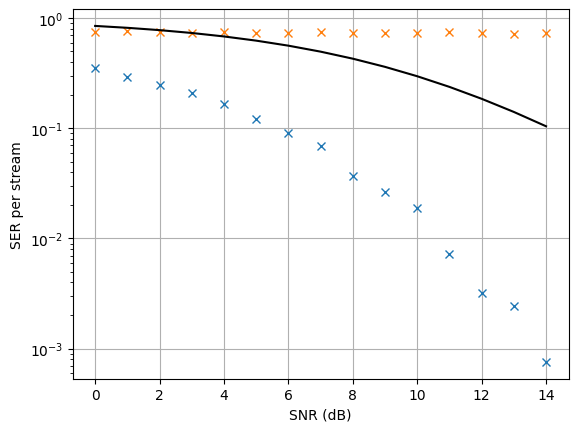

In [11]:
 P_err_linear = 1.0/((1 + ((N_Rx/M_Tx)*SNR_lin_th)/(2*N_Rx))**N_Rx)
plt.figure()
for rx in range(N_Rx):
    plt.semilogy(SNRdB, SER[rx,:], 'x')

plt.semilogy(SNRdB, P_err_linear, 'k-')
plt.xlabel('SNR (dB)')
plt.ylabel('SER per stream')
plt.grid(True)

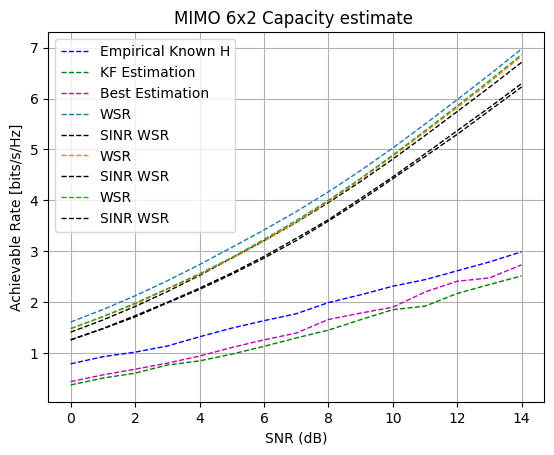

In [13]:
plt.figure()
#for rx in range(3):
plt.plot(SNRdB, Rate[0,:],  'b--', linewidth=1, label='Empirical Known H')
plt.plot(SNRdB, Rate[1,:],  'g--', linewidth=1, label='KF Estimation')
plt.plot(SNRdB, Rate[2,:],  'm--', linewidth=1, label='Best Estimation')
for rx in range(3):
  plt.plot(SNRdB, RateNir[rx,:],  '--', linewidth=1, label='WSR')
  plt.plot(SNRdB, RateSINR[rx,:], 'k--', linewidth=1, label='SINR WSR')


plt.xlabel('SNR (dB)')
plt.ylabel('Achievable Rate [bits/s/Hz]')
plt.title('MIMO 6x2 Capacity estimate ')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

